# Introduction
Fashion-MNIST is a dataset of  images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 pixel grayscale image, associated with a label from 10 classes. It is split in 10,000 as test and 50,000 as train datasets.
It consists images of T-shirt,Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

# Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense, Flatten, Dropout,MaxPool2D
# loading data
from keras.datasets import fashion_mnist
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# print version of tensorflow
print(tf.__version__)

2.3.1


## Load Data
First step of any machine learning project is to load the data and divide it into a training and testing dataset. The MNIST dataset can be downloaded directly from tensorflow datasets.

Here, our training and testing images are 28 X 28 grayscale image of clothes. Our aim is to train the model to predict the image of the clothes.
Labels for the images in our fashion_mnist dataset are     'Tshirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'

In [2]:
(train_images, train_labels),(test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Understanding Data
Fashion MNIST data is already preprocessed so we do not have to preprocess it. 
So, let's surfacely look data

In [3]:
print("Train Images Shape: ", train_images.shape)
print("Train Labels Shape: ", train_labels.shape)
print("Test Images Shape: ", test_images.shape)
print("Test Labels Shape: ", test_labels.shape)
print('_' * 50)
labels = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(labels)

Train Images Shape:  (60000, 28, 28)
Train Labels Shape:  (60000,)
Test Images Shape:  (10000, 28, 28)
Test Labels Shape:  (10000,)
__________________________________________________
['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Split data for validation and testing
Here, we will divide testing data into validation data and testing data so that we can use validation data to avoid overfitting and can use testing data to test the performance of our CNN model.
Here we have used 90% of our test data for validation and remaining 10% for testing

In [4]:
val_images = test_images[:9000]
val_labels = test_labels[:9000]
test_images = test_images[9000:]
test_labels = test_labels[9000:]

# Visualizing Data

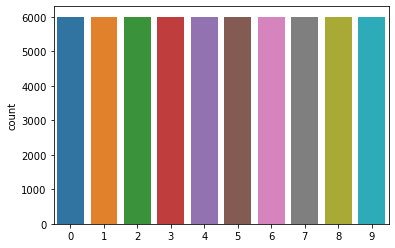

In [5]:
sns.countplot(train_labels)
plt.show()  

Let's visualize image in our dataset

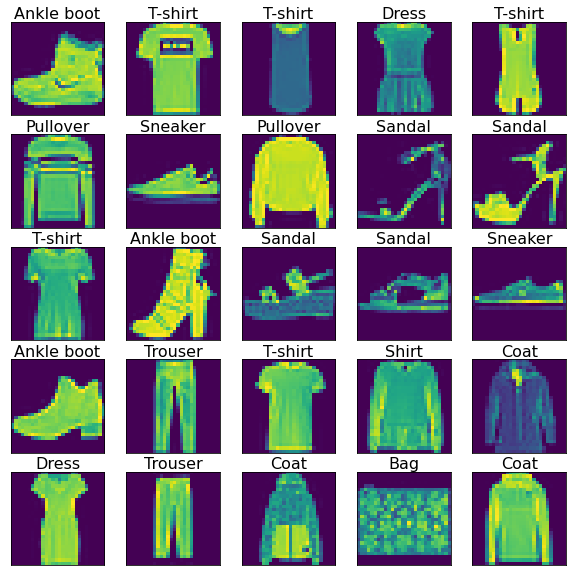

In [6]:
plt.figure(figsize = (10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.title(str(labels[train_labels[i]]),fontsize = 16, color = 'black', pad = 2)
  plt.imshow(train_images[i] )
  plt.xticks([])
  plt.yticks([])

plt.show()  

# Normalization and Reshaping


Here, pixel value for our training and testing images are in range between 0 to 255. In order to reduce data inconsistency we have to normalize the data

The dimension of tensor convolution layer except doesn't match with the dimension we have , so we have to reshape our data

Here, train images have maximum value of 255. and minimum value of 0. So, for normalizing we simply can divide data by 255


x = (x - x.min()) / (x.max() - x.min())


In [7]:
#reshaping train_images
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2],1)
#normalizing 
train_images = train_images / 255.0
# reshaping test_images
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2],1)
# normalizing
test_images = test_images / 255.0
#reshaping validation images
val_images = val_images.reshape(val_images.shape[0], val_images.shape[1], val_images.shape[2],1)
# normalizing 
val_images = val_images / 255.0

## Label Encoding
In this technique, each label is assigned a unique integer based on alphabetical ordering.
For example Ankle Boot becomes [0,0,0,0,0,0,0,0,0,1]

In [8]:
val_labels = tf.one_hot(val_labels.astype(np.int32), depth = 10)
train_labels = tf.one_hot(train_labels.astype(np.int32), depth = 10 )
test_labels = tf.one_hot(test_labels.astype(np.int32), depth = 10)

# Building CNN Model
Here, we will build our model using Sequential API

In [9]:

model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (2, 2), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu'))
# 10 units in the last Dense layer as there are 10 classes to be classified into
model.add(Dense(units = 10, activation = 'softmax'))

# printing the summary of the model 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                1

### Compile model

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

### Callback
Here, we will use Callback so that training of our model stops when we reach certain validation accuracy


In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('val_acc')>0.900):
      print("Accuracy has reached over 90% .. Stopping training !!!!")
      self.model.stop_training = True

callba = myCallback()      

### Fitting model

In [12]:
EPOCHS = 30
BATCH_SIZE = 64
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, 
                    epochs = EPOCHS, verbose = 2, validation_data = (val_images, val_labels),
                    callbacks = myCallback())

Epoch 1/30
938/938 - 4s - loss: 0.8462 - acc: 0.6925 - val_loss: 0.5562 - val_acc: 0.7999
Epoch 2/30
938/938 - 4s - loss: 0.4753 - acc: 0.8301 - val_loss: 0.4516 - val_acc: 0.8397
Epoch 3/30
938/938 - 3s - loss: 0.4093 - acc: 0.8563 - val_loss: 0.3932 - val_acc: 0.8583
Epoch 4/30
938/938 - 3s - loss: 0.3773 - acc: 0.8653 - val_loss: 0.4062 - val_acc: 0.8543
Epoch 5/30
938/938 - 3s - loss: 0.3541 - acc: 0.8740 - val_loss: 0.3528 - val_acc: 0.8714
Epoch 6/30
938/938 - 3s - loss: 0.3376 - acc: 0.8801 - val_loss: 0.3519 - val_acc: 0.8692
Epoch 7/30
938/938 - 3s - loss: 0.3227 - acc: 0.8832 - val_loss: 0.3297 - val_acc: 0.8834
Epoch 8/30
938/938 - 3s - loss: 0.3104 - acc: 0.8886 - val_loss: 0.3268 - val_acc: 0.8797
Epoch 9/30
938/938 - 3s - loss: 0.2990 - acc: 0.8924 - val_loss: 0.3293 - val_acc: 0.8806
Epoch 10/30
938/938 - 3s - loss: 0.2893 - acc: 0.8944 - val_loss: 0.3104 - val_acc: 0.8882
Epoch 11/30
938/938 - 3s - loss: 0.2808 - acc: 0.8984 - val_loss: 0.3050 - val_acc: 0.8900
Epoch 12

# Model Evaluation


 #### Loss and Accuracy Curves




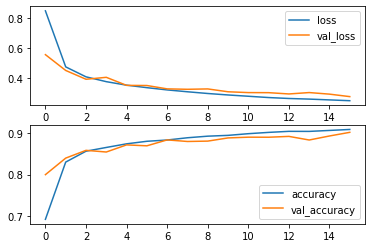

In [13]:
plt.subplot(2,1,1)
plt.plot( history.history['loss'], label = 'loss')
plt.plot( history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'best')
plt.subplot(2,1,2)
plt.plot( history.history['acc'], label = 'accuracy')
plt.plot( history.history['val_acc'], label = 'val_accuracy')
plt.legend(loc = 'best')
plt.show()

In [14]:
print("Final Accuracy:",np.round(model.evaluate(test_images, test_labels)[1] * 100,2))

32/32 [==============================] - 0s 2ms/step - loss: 0.2693 - acc: 0.8990
Final Accuracy: 89.9


### Image Plot
Here, we will plot our testing images.
Image with green title refers to the correct predction while images with red title refers to incorrect prediction

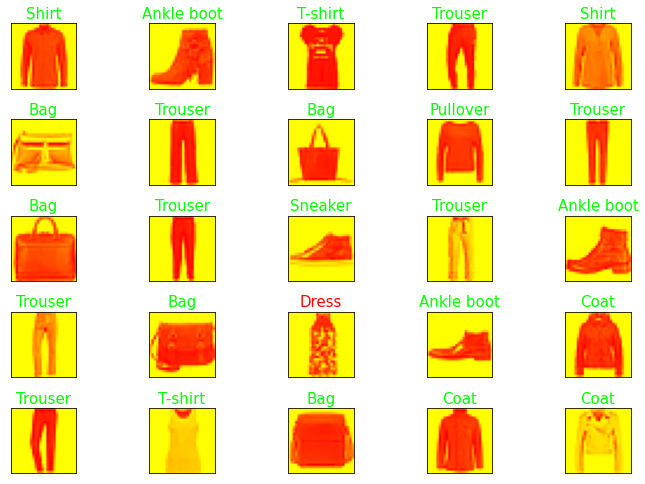

In [15]:
predict = model.predict(test_images)
plt.figure(figsize = (10,7))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout(pad = 1)
  plt.imshow(test_images.reshape( test_images.shape[0],28,28)[i], cmap = plt.cm.autumn_r)
  if labels[np.argmax(predict[i])] != labels[np.argmax(test_labels[i])]:
      plt.title(str(labels[np.argmax(predict[i])]), fontsize = 15, color = 'red',pad = 5)
  else:
    plt.title(str(labels[np.argmax(predict[i])]), fontsize = 15, color = 'lime',pad = 5)    
  plt.xticks([])
  plt.yticks([])

### Confusion Matrix

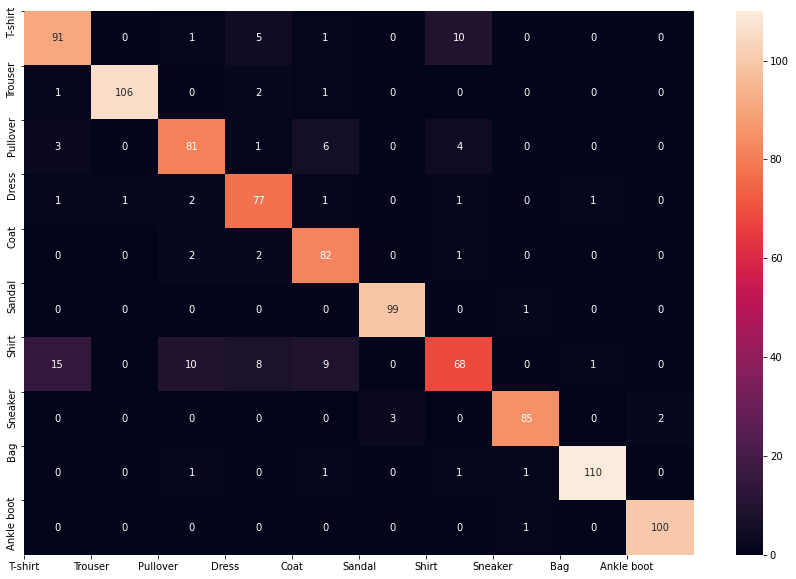

In [16]:
from sklearn.metrics import confusion_matrix
#predicted values
y_pred = np.argmax(predict,axis = 1) 
# true values
y_true = np.argmax(test_labels,axis = 1)
# compute the confusion matrix
matrix = confusion_matrix(y_true, y_pred) 

plt.figure(figsize = (15,10) )
sns.heatmap(matrix, annot = True, fmt = 'g')
plt.xticks(ticks = range(10) ,labels = labels)
plt.yticks(ticks = range(10) ,labels = labels)
plt.show()

Here, we can see that our model is bit confuse between (T-shirt and Shirt) and (Shirt and Pullover)

### Classification Report

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       108
           1       0.99      0.96      0.98       110
           2       0.84      0.85      0.84        95
           3       0.81      0.92      0.86        84
           4       0.81      0.94      0.87        87
           5       0.97      0.99      0.98       100
           6       0.80      0.61      0.69       111
           7       0.97      0.94      0.96        90
           8       0.98      0.96      0.97       114
           9       0.98      0.99      0.99       101

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000




### Feel free to comment and upvote. Any suggestion to improve my kernel is really appreciated
### Thanks For your visit .... 